In [1]:
from tensorflow import keras
from keras.preprocessing.sequence import TimeseriesGenerator
from keras import layers
from sklearn.preprocessing import MinMaxScaler


2023-05-21 22:16:52.614416: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-21 22:16:52.661072: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-21 22:16:52.661918: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-21 22:16:53.609563: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
import logging
logging.getLogger('tensorflow').setLevel(logging.ERROR)
logging.getLogger('keras').setLevel(logging.ERROR)


In [3]:
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objs as go
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
import pickle 



In [4]:
df = pd.read_csv('ddb_output.csv')
df.rename(columns={'humidity.S': 'humidity',
                   'temperature.S':'temperature',
                   'timestamp.S':'timestamp'},inplace=True)
df.drop(columns=['Unnamed: 0'],inplace=True)
#df.reset_index(drop=True,inplace=True)
df.sort_values(by='timestamp',inplace=True)


### Baseline - persistence forecast 1,2,4 hours in advance

In [5]:
df_temp =  df[ df['timestamp'] > str(pd.Timestamp('2023-04-28')) ].drop(columns=['humidity'])
df_temp.reset_index(inplace=True,drop=True)

df_temp['timestamp'] = df_temp['timestamp'].apply(lambda x: pd.to_datetime(x)) 
df_temp['timestamp'] = df_temp['timestamp'].dt.round('5min')

df_temp.set_index('timestamp',inplace=True)
df_temp.dropna(inplace=True)

In [6]:
# Split the data, 50% in training and 25% in validation, 25% in test, and not randomly selected since this is a time series

scaler = MinMaxScaler()

last_train_index = int(np.round(df_temp['temperature'].shape[0]*0.5))
last_val_index = int(np.round(df_temp['temperature'].shape[0]*0.75))

train_data = df_temp.iloc[:last_train_index,]
validation_data = df_temp.iloc[last_train_index:last_val_index]
test_data = df_temp.iloc[last_val_index:]

# Fit to the train set, then transform the train set and the test set
# TODO: Check, should not fit on test set?

scaler.fit(train_data)
scaled_train = scaler.transform(train_data)
scaled_validation = scaler.transform(validation_data)
scaled_test = scaler.transform(test_data)


In [7]:
delay = 12
sequence_length = 36

train = keras.preprocessing.timeseries_dataset_from_array(scaled_train[:-delay], scaled_train[sequence_length+delay:], 
                            sequence_length=sequence_length, batch_size=1, shuffle=True)

validation = keras.preprocessing.timeseries_dataset_from_array(scaled_validation[:-delay], scaled_validation[sequence_length+delay:], 
                            sequence_length=sequence_length, batch_size=1, shuffle=True)

test = keras.preprocessing.timeseries_dataset_from_array(scaled_test[:-delay], scaled_test[sequence_length+delay:], 
                            sequence_length=sequence_length, batch_size=1, shuffle=True)




Epoch 1/10


2023-05-21 22:17:27.649402: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-21 22:17:27.651997: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-21 22:17:27.654189: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

995/998 [============================>.] - ETA: 0s - loss: 0.0162 - mae: 0.0667

2023-05-21 22:17:45.097311: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_28' with dtype int32 and shape [475]
	 [[{{node Placeholder/_28}}]]
2023-05-21 22:17:45.098564: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [511,1]
	 [[{{node Placeholder/_0}}]]
2023-05-21 22:17:45.364048: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim'


Epoch 1: val_loss improved from inf to 0.00699, saving model to model_checkpoint_early_stopping.h5
998/998 [==============================] - 19s 17ms/step - loss: 0.0162 - mae: 0.0667 - val_loss: 0.0070 - val_mae: 0.0706
Epoch 2/10
998/998 [==============================] - ETA: 0s - loss: 0.0031 - mae: 0.0427
Epoch 2: val_loss improved from 0.00699 to 0.00557, saving model to model_checkpoint_early_stopping.h5
998/998 [==============================] - 14s 14ms/step - loss: 0.0031 - mae: 0.0427 - val_loss: 0.0056 - val_mae: 0.0605
Epoch 3/10
996/998 [============================>.] - ETA: 0s - loss: 0.0026 - mae: 0.0385
Epoch 3: val_loss improved from 0.00557 to 0.00433, saving model to model_checkpoint_early_stopping.h5
998/998 [==============================] - 14s 14ms/step - loss: 0.0026 - mae: 0.0386 - val_loss: 0.0043 - val_mae: 0.0537
Epoch 4/10
998/998 [==============================] - ETA: 0s - loss: 0.0023 - mae: 0.0358
Epoch 4: val_loss improved from 0.00433 to 0.00370, 

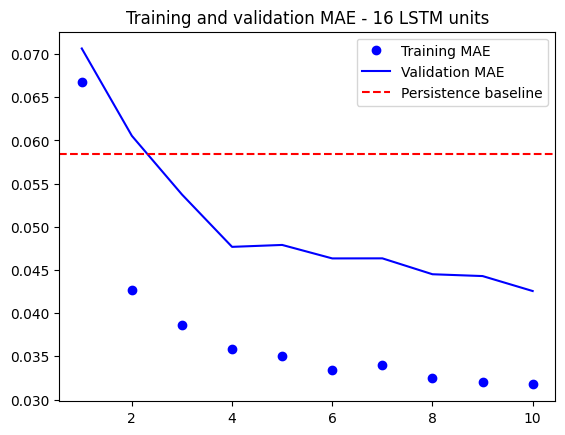

In [8]:
# See if early stopping does any better

inputs = keras.Input(shape=(36, 1))

x = layers.LSTM(16)(inputs)
outputs = layers.Dense(1)(x)

model = keras.Model(inputs, outputs)

model.compile(optimizer="adam", loss="mse", metrics=["mae"])

path_checkpoint = f"model_checkpoint_early_stopping.h5"
es_callback = keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=0, patience=5)

modelckpt_callback = keras.callbacks.ModelCheckpoint(
    monitor="val_loss",
    filepath=path_checkpoint,
    verbose=1,
    save_weights_only=True,
    save_best_only=True,
    )

history = model.fit(train,
                    epochs=10,
                    validation_data=validation,
                        callbacks=[es_callback, modelckpt_callback],
                    )


loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)

persistence_mae = 0.0584

plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.axhline(y=persistence_mae, color='r', linestyle='--', label='Persistence baseline')
plt.title(f'Training and validation MAE - 16 LSTM units')
plt.legend()
plt.show()

In [9]:
eval_result = model.evaluate(test)[1]
print("[test results]:", eval_result)
print(f'Persistence: {persistence_mae}') # Ok, so that's not great

 24/475 [>.............................] - ETA: 2s - loss: 0.0061 - mae: 0.0654

2023-05-21 22:21:33.330250: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_20' with dtype double and shape [475,1]
	 [[{{node Placeholder/_20}}]]
2023-05-21 22:21:33.331654: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_8' with dtype int32 and shape [475]
	 [[{{node Placeholder/_8}}]]


475/475 [==============================] - 2s 3ms/step - loss: 0.0069 - mae: 0.0681
[test results]: 0.06807822734117508
Persistence: 0.0584


In [9]:
import keras_tuner as kt

In [10]:
def model_builder(hp):
  hp_dropout = hp.Choice('dropout', values=[0.0, 0.1, 0.2, 0.3])
  hp_recurrent_dropout = hp.Choice('recurrent_droput', values=[0.0, 0.1, 0.2, 0.3])
   
  inputs = keras.Input(shape=(36, 1))
  x = layers.LSTM(16, 
                  dropout=hp_dropout, 
                  recurrent_dropout=hp_recurrent_dropout)(inputs)
  outputs = layers.Dense(1)(x)

  model = keras.Model(inputs, outputs)

  model.compile(optimizer="adam", loss="mse", metrics=["mae"])

  return model


In [11]:
tuner = kt.Hyperband(model_builder,
                objective='val_loss', # legacy version https://stackoverflow.com/questions/39883331/plotting-learning-curve-in-keras-gives-keyerror-val-acc ??
                max_epochs=10,
                factor=3,
                directory='my_dir',
                project_name='intro_to_kt')

stop_early = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

tuner.search(train,epochs=10,validation_data=validation,
                          callbacks=[stop_early])

best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. The optimal rate of dropout for the input
layer is {best_hps.get('dropout')} and the rate of recurrent dropout 
is {best_hps.get('learning_rate')}.
""")


The hyperparameter search is complete. The optimal rate of dropout for the input
layer is 0.0 and the rate of recurrent dropout 
is 0.0.



In [12]:
# Build the model with the optimal hyperparameters and train it on the data for 50 epochs
model = tuner.hypermodel.build(best_hps)
history = model.fit(train, epochs=50, validation_data=validation)

val_loss_per_epoch = history.history['val_loss']

Epoch 1/50
998/998 [==============================] - 5s 4ms/step - loss: 0.0066 - mae: 0.0548 - val_loss: 0.0060 - val_mae: 0.0645
Epoch 2/50
998/998 [==============================] - 4s 4ms/step - loss: 0.0029 - mae: 0.0419 - val_loss: 0.0050 - val_mae: 0.0583
Epoch 3/50
998/998 [==============================] - 4s 4ms/step - loss: 0.0026 - mae: 0.0380 - val_loss: 0.0055 - val_mae: 0.0583
Epoch 4/50
998/998 [==============================] - 4s 4ms/step - loss: 0.0022 - mae: 0.0362 - val_loss: 0.0034 - val_mae: 0.0475
Epoch 5/50
998/998 [==============================] - 4s 4ms/step - loss: 0.0020 - mae: 0.0340 - val_loss: 0.0031 - val_mae: 0.0423
Epoch 6/50
998/998 [==============================] - 4s 4ms/step - loss: 0.0019 - mae: 0.0331 - val_loss: 0.0030 - val_mae: 0.0440
Epoch 7/50
998/998 [==============================] - 4s 4ms/step - loss: 0.0018 - mae: 0.0319 - val_loss: 0.0029 - val_mae: 0.0422
Epoch 8/50
998/998 [==============================] - 4s 4ms/step - loss: 0.

KeyboardInterrupt: 

In [ ]:
best_epoch = val_loss_per_epoch.index(min(val_loss_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

Best epoch: 38


In [ ]:
# Re-instantiate the hypermodel and train it with the optimal number of epochs from above.

hypermodel = tuner.hypermodel.build(best_hps)

hypermodel.fit(train, epochs=best_epoch, validation_data=validation)

Epoch 1/38
998/998 [==============================] - 5s 4ms/step - loss: 0.0091 - mae: 0.0570 - val_loss: 0.0063 - val_mae: 0.0647
Epoch 2/38
998/998 [==============================] - 4s 4ms/step - loss: 0.0030 - mae: 0.0417 - val_loss: 0.0063 - val_mae: 0.0637
Epoch 3/38
998/998 [==============================] - 4s 4ms/step - loss: 0.0026 - mae: 0.0386 - val_loss: 0.0054 - val_mae: 0.0583
Epoch 4/38
998/998 [==============================] - 4s 4ms/step - loss: 0.0023 - mae: 0.0360 - val_loss: 0.0054 - val_mae: 0.0573
Epoch 5/38
998/998 [==============================] - 4s 4ms/step - loss: 0.0021 - mae: 0.0348 - val_loss: 0.0039 - val_mae: 0.0485
Epoch 6/38
998/998 [==============================] - 4s 4ms/step - loss: 0.0021 - mae: 0.0340 - val_loss: 0.0066 - val_mae: 0.0650
Epoch 7/38
998/998 [==============================] - 4s 4ms/step - loss: 0.0019 - mae: 0.0329 - val_loss: 0.0056 - val_mae: 0.0583
Epoch 8/38
998/998 [==============================] - 4s 4ms/step - loss: 0.

In [ ]:
eval_result = hypermodel.evaluate(test)[1]
print("[test results]:", eval_result)
print(f'Persistence: {persistence_mae}') # Ok, so that's not great

475/475 [==============================] - 1s 1ms/step - loss: 0.0068 - mae: 0.0656
[test results]: 0.06557800620794296
Persistence: 0.0584


In [ ]:
model = hypermodel  # Get model (Sequential, Functional Model, or Model subclass)
model
model.save('trained_lstm_optimised')